# Model Evaluation

There are several points we want to address here:

- Which one is the best traditional ML method for our purpose > [Determine Main Model](#Determine-Main-Model)
- Find good hyperparameter for our ML method > [Hyperparameter Tuning](#Hyperparameter-Tuning)
- Determine which feature creation approach performs best > [Target Word Set Evaluation](#Target-Word-Set-Evaluation)

## Evaluation Metrics

We are dealing with a multi-class classification problem and from our [data exploration notebook](reviewed_grapes.data_exp.pandas.v1.ipynb) we know that
the dataset is unbalanced, i.e. some labels occur more often than others.

In such a case it can be problematic to use prediction accuracy as metric.
This is because the model only needs to have a good precision on the most prevalent classes in order to gain a high evaluation score.

What is the best evaluation metric does, of course, depend on what you want to achieve with your model.
The very goal might be to get as many predictions right as possible and you don't care if your model does a very bad job in predicting the less frequently present classes.
In this case you might stick to accuracy as evaluation even if your dataset is unbalanced.
On the other hand, if each class is equally important to you, no matter the frequency it is present in your dataset, then you might want to assess of often your model predicts them.
In this case you might want to consider the [recall](https://en.wikipedia.org/wiki/Recall_(information_retrieval)) of your classes, and a measure like the macro-averaged [F-score](https://en.wikipedia.org/wiki/F1_score) might be an adequate evaluation metric.

In this case we care about how many predictions we get right overall and don't care so much about whether or not our model manages to pick up all the wine varieties.
**Our main evaluation metric will thus be accuracy.**
However, we will also report the F-score, just so we can consider an addition dimension when evaluation our models.

_For the respective definitions of these metrics have a look at [sparks multi-class evaluation metrics](https://spark.apache.org/docs/3.1.1/mllib-evaluation-metrics.html#label-based-metrics)._

In [1]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from functools import partial
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from pyspark import keyword_only
from pyspark.ml import Pipeline, Transformer, Estimator, Model
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasOutputCols, Param, Params
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import lit, udf
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jonas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%matplotlib inline
def warn(string):
    display(Markdown('<span style="color:red">'+string+'</span>'))
def info(string):
    display(Markdown('<span style="color:blue">'+string+'</span>'))

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.driver.memory", "20g") \
    .appName("jojoSparkSession") \
    .getOrCreate()
    # .config("spark.driver.memory", "20g") \
    # .config("spark.default.parallelism", "16") \
    # .config("spark.executor.cores", "16") \
sc = spark.sparkContext
sqlContext = SQLContext(sc) 

In [1]:
from reviewed_grapes.transformers import NLTKLemmatizer
from utils.Estimators import WordSetTracker

[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Determine Main Model

We pick the best performing model among:

- [Random Forest Classifier](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html)
- [Boosted Gradient Trees](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassificationModel.html) (with [1-vs-rest wrapping](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.OneVsRest.html))
- [Naive Bayes](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html)
- [Multinomial Logistic Regression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)


In [7]:
si = StringIndexer(inputCol='variety', outputCol='label')

In [8]:
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))
# we also define a custom blacklist:
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
# complete the list with our custom blacklist:
stop_words = list(en_stopwords.union(blacklist))
# instatiate our transformer and the estimator:
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)

In [9]:
# we'll stick to only 150 words for now
nbrWords = 150
with open('data/targetWordSets/common_words.json', 'r') as fo:
    common_words = json.load(fo)
wst_common = WordSetTracker(inputCol='words', outputCol='features', wordSet=common_words, limitTo=nbrWords)
# wst_similar = WordSetTracker(inputCol='words', outputCol='features', wordSet=similar_words)
# wst_dissimilar = WordSetTracker(inputCol='words', outputCol='features', wordSet=dissimilar_words)
# wst_extremes = WordSetTracker(inputCol='words', outputCol='features', wordSet=extremes_words)
# wst_lowentropy = WordSetTracker(inputCol='words', outputCol='features', wordSet=lowentropy_words)

**Lets load the dataset and split it so that so we can test for overfitting later:**

In [9]:
# load the dataset
reviews_sdf = spark.read.parquet('data/reviews_cleaned')
df_train, df_test = reviews_sdf.randomSplit([0.9, 0.1])

Let's already do a pipeline for the first 3 steps.
They will be the same no matter what ML method we use.
We can transform the data once with this pipeline and then used the transformed dataset with the different ML models:

In [10]:
preview_model = Pipeline(stages=[si, nltkl, wst_common]).fit(reviews_sdf)

In [11]:
ready_train = preview_model.transform(df_train).toDF('id', 'description', 'variety', 'label', 'words', 'features')
ready_test = preview_model.transform(df_test).toDF('id', 'description', 'variety', 'label', 'words', 'features')
ready_train.show()

+---+--------------------+------------------+-----+--------------------+--------------------+
| id|         description|           variety|label|               words|            features|
+---+--------------------+------------------+-----+--------------------+--------------------+
|  0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|(150,[1,3,4,5,9,2...|
|  1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|(150,[1,5,6,8,14,...|
|  2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|(150,[0,5,29,49,6...|
|  3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|(150,[2,3,4,10,55...|
|  7|this dry and rest...|    gewürztraminer| 26.0|[firm, much, offe...|(150,[5,9,12,21,2...|
|  8|savory dried thym...|    gewürztraminer| 26.0|[accent, elegant,...|(150,[0,9,10,18,4...|
|  9|this has great de...|        pinot gris| 19.0|[pear, flavor, de...|(150,[0,1,5,9,12,...|
| 10|soft, supple plum...|cabernet sauvignon|  2.0|[result, 

We need metrics to evaluate how well our models perform.

We use the _accuracy_ to get a measure we can easily interpret.
Recall that our **baseline model had an accuracy of ~11%**.
Any model that performs worse than that is of no use for us!

In [14]:
accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

We are all set to start fitting different ML models and see how well they perform:

---
### Random Forest Classifier

Various values for `nbrTrees` as well as `maxTreeDepth` were tested. Generally **more trees decrease the risk of overfitting**. The values here below correspond to a trade-off between computational requirements and model performance.

In [15]:
nbrTrees = 250
maxTreeDepth = 10
model_path_1 = f'data/evaluation/RFC_{nbrWords}words_{nbrTrees}trees_{maxTreeDepth}depth'

In [16]:
from pyspark.ml.classification import RandomForestClassifier

In [17]:
%%time
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='label',
                             numTrees=nbrTrees,
                             maxMemoryInMB=256,
                             maxDepth=maxTreeDepth)
ppl_1 = Pipeline(stages=[rfc])
model_1 = ppl_1.fit(ready_train)
pred_train_1 = model_1.transform(ready_train)
model_1.write().overwrite().save(model_path_1)
pred_train_1.show()  # we force the lazy execution

+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|           variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|(150,[1,3,4,5,9,2...|[7.92469783215327...|[0.03169879132861...|       1.0|
|  1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|(150,[1,5,6,8,14,...|[41.2849385743962...|[0.16513975429758...|       4.0|
|  2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|(150,[0,5,29,49,6...|[12.1926608195630...|[0.04877064327825...|       1.0|
|  3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|(150,[2,3,4,10,55...|[12.6352659793370...|[0.0

In [25]:
# in case the model was already saved we can also just load it here:
model_1 = PipelineModel.load(model_path_1)
pred_train_1 = model_1.transform(ready_train)

In [18]:
info('How well is random forest doing?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_train_1), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_train_1), 4)}**')

<span style="color:blue">How well is random forest doing?:</span>

<span style="color:blue">Accuracy: **34.9%**</span>

<span style="color:blue">F1 score: **0.2544**</span>

In [19]:
pred_test_1 = model_1.transform(ready_test)
info('How well are we doing on the test dataset?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_test_1), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_test_1), 4)}**')

<span style="color:blue">How well are we doing on the test dataset?:</span>

<span style="color:blue">Accuracy: **34.0%**</span>

<span style="color:blue">F1 score: **0.2427**</span>

---
### Gradient-boosted Tree Classifier (with 1-vs-all)

This classifier currently only supports binary labels, so we use the 1-vs-all reduction to create an estimator that supports multi-class labels.

Due to the prolonged training time it was not possible to carry out a more thorough hyperparameter exploration.

The significant overfitting as well as the computational requirements make this a less favorable candidate.

In [14]:
from pyspark.ml.classification import GBTClassifier, OneVsRest

In [15]:
maxTreeDepth = 10
model_path_2 = f'data/evaluation/GBTC1vaA_{nbrWords}words_{maxTreeDepth}depth'

In [22]:
%%time
gbtc =  GBTClassifier(featuresCol='features', labelCol='label', maxDepth=maxTreeDepth)
ovr = OneVsRest(classifier=gbtc)
ppl_2 = Pipeline(stages=[ovr])
model_2 = ppl_2.fit(ready_train)
pred_train_2 = model_2.transform(ready_train)
model_2.write().overwrite().save(model_path_2)

CPU times: user 3.82 s, sys: 2.07 s, total: 5.88 s
Wall time: 4h 6min 47s


In [17]:
model_2 = PipelineModel.load(model_path_2)
pred_train_2 = model_2.transform(ready_train)

In [23]:
info('How well is the 1-vs-all gradient-boosted tree doing?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_train_2), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_train_2), 4)}**')

<span style="color:blue">How well is the 1-vs-all gradient-boosted tree doing?:</span>

<span style="color:blue">Accuracy: **70.3%**</span>

<span style="color:blue">F1 score: **0.704**</span>

In [24]:
pred_test_2 = model_2.transform(ready_test)
info('How well are we doing on the test dataset?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_test_2), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_test_2), 4)}**')

<span style="color:blue">How well are we doing on the test dataset?:</span>

<span style="color:blue">Accuracy: **38.5%**</span>

<span style="color:blue">F1 score: **0.3513**</span>

---
### Bernoulli Naive Bayes 

This classifier can be efficiently trained but it assumes independance between the features, which is likely not the case four our dataset.

In [22]:
from pyspark.ml.classification import NaiveBayes

In [23]:
model_path_3 = f'data/evaluation/BNB_{nbrWords}words'

In [24]:
%%time
nbc = NaiveBayes(smoothing=1.0, modelType="bernoulli")
ppl_3 = Pipeline(stages=[nbc])
model_3 = ppl_3.fit(ready_train)
pred_train_3 = model_3.transform(ready_train)
model_3.write().overwrite().save(model_path_3)
pred_train_3.show()

+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|             variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| 33|rustic and dry, t...|           red blend|  3.0|[currants, flavor...|(150,[0,9,12,16,4...|[-34.965445881990...|[1.90884982438553...|       3.0|
| 48|this bottling res...|     sauvignon blanc|  6.0|[grapefruit, crac...|(150,[0,1,3,4,92,...|[-35.545715272081...|[0.00885880379241...|       6.0|
| 67|a blend of merlot...|bordeaux-style re...|  4.0|[vanilla, woody, ...|(150,[0,3,7,10,12...|[-52.339116672758...|[3.97442587774491...|       3.0|
| 93|freshness charact...|    grüner veltliner| 22.0|[pear, characteri...|(150,[0,4,10,15,1...|[-39.962824

In [66]:
model_3 = PipelineModel.load(model_path_3)
pred_train_3 = model_3.transform(ready_train)

In [25]:
info('How well is naive bayes doing?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_train_3), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_train_3), 4)}**')

<span style="color:blue">How well is naive bayes doing?:</span>

<span style="color:blue">Accuracy: **39.300000000000004%**</span>

<span style="color:blue">F1 score: **0.3827**</span>

In [26]:
pred_test_3 = model_3.transform(ready_test)
info('How well are we doing on the test dataset?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_test_3), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_test_3), 4)}**')

<span style="color:blue">How well are we doing on the test dataset?:</span>

<span style="color:blue">Accuracy: **38.5%**</span>

<span style="color:blue">F1 score: **0.375**</span>

---
### Multinomial Logistic Regression

This classifier is basically a feed-forward networks without hidden layer.

In [8]:
from pyspark.ml.classification import LogisticRegression

In [28]:
model_path_4 = f'data/evaluation/MLRC_{nbrWords}words'

In [29]:
%%time
mlrc = LogisticRegression(regParam=0.01, elasticNetParam=0.01)
ppl_4 = Pipeline(stages=[mlrc])
model_4 = ppl_4.fit(ready_train)
pred_train_4 = model_4.transform(ready_train)
model_4.write().overwrite().save(model_path_4)
pred_train_4.show()

+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|             variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| 33|rustic and dry, t...|           red blend|  3.0|[currants, flavor...|(150,[0,9,12,16,4...|[0.68166036430532...|[0.00994867262745...|       3.0|
| 48|this bottling res...|     sauvignon blanc|  6.0|[grapefruit, crac...|(150,[0,1,3,4,92,...|[1.93939034829799...|[0.05007627897285...|       6.0|
| 67|a blend of merlot...|bordeaux-style re...|  4.0|[vanilla, woody, ...|(150,[0,3,7,10,12...|[0.53756285617736...|[0.00133601727798...|       4.0|
| 93|freshness charact...|    grüner veltliner| 22.0|[pear, characteri...|(150,[0,4,10,15,1...|[0.77758378

In [ ]:
model_4 = PipelineModel.load(model_path_4)
pred_train_4 = model_4.transform(ready_train)

In [30]:
info('How well is the multinomial logistic regression doing?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_train_4), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_train_4), 4)}**')

<span style="color:blue">How well is the multinomial logistic regression doing?:</span>

<span style="color:blue">Accuracy: **42.5%**</span>

<span style="color:blue">F1 score: **0.3674**</span>

In [31]:
pred_test_4 = model_4.transform(ready_test)
info('How well are we doing on the test dataset?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_test_4), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_test_4), 4)}**')

<span style="color:blue">How well are we doing on the test dataset?:</span>

<span style="color:blue">Accuracy: **41.5%**</span>

<span style="color:blue">F1 score: **0.3565**</span>

---
## Fazit:

_With accuracy ranging from 1/3 to 2/9, random forests, naive bayes and logistic regression all perform better than the marginal case (baseline model) which had an accuracy of around 1/9._

So the first take home message is:

**Wine reviews are not just purple gibberish, they actually contain some information about the wine variety under judgment.**

Before we start comparing the models it should be mentioned that the system these model were trained on had to rely on swap-space during the training.
Writing out RAM to disk slows down a process and thus the wall time of each process is a poor indicator for the computational expense as it is also
affected by the amount of active memory required.

**Random Forests** are known to be computationally expensive and perform relatively poorly on test data.
In the case at hand the former can be confirmed, they take roughly 3 times the time to train as multinomial logistic regression, but still perform worse.
What concerns the latter, the tendency to overfit could be reduced by increasing the number of trees in the forest.
This, however, results in a trade-off between overfitting and computational expense.

**Gradient-boosted Trees** are faster and generally outperform random forests. But one needs to take into account that this might only apply to binary classification.
As of spark 3.x the implementation of gradient-boosted trees only support binary classifications and needs to be embedded in a 1-vs-all routine in order to handle multi-classed labels. For the case at hand, with ~50 distinct labels, this results in a computational overhead placing this approach at a distant last in terms of computational time.
In terms of accuracy, as well as, harmonic mean it performs roughly equally well as logistic regression.
However the computational cost of this method is by no means comparable.

The **Naive Bayes** likelyhood estimation can be efficiently trained, resulting in the shortest wall time.
In terms of performance this method only outperforms random forest.

Finally the **Multinomial Logistic Regression** is both, comparatively fast and performs well.


**We will use `LogisticRegression` as our main ML model!**

---
---

# Hyperparameter Tuning

Here we have a closer look at logistic regression and try to increase performance via hyperparameter tuning.

Recall that our custom WordSetTracker also had a hyperparameter, i.e. the number of tracked words.
We will include this hyperparameter in our tuning as well.

One way to avoid simply tweaking manually is by carrying out a [cross validation](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation).
In short for a given set of hyperparameters we split our training data repeatedly and assess the average performance. 
We do this over a grid of hyperparameters and identify the best configuration in this gird.

In [6]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [7]:
si = StringIndexer(inputCol='variety', outputCol='label')
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))
# we also define a custom blacklist:
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
# complete the list with our custom blacklist:
stop_words = list(en_stopwords.union(blacklist))
# instatiate our transformer and the estimator:
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)
# we'll stick to only 150 words for now
nbrWords = 150
with open('data/targetWordSets/common_words.json', 'r') as fo:
    common_words = json.load(fo)
wst_common = WordSetTracker(inputCol='words', outputCol='features', wordSet=common_words, limitTo=nbrWords)
wst = WordSetTracker(inputCol='words', outputCol='features', limitTo=nbrWords)

To start we only apply the lemmatization and use the resulting dataset:

In [14]:
lemmatized = Pipeline(stages=[si, nltkl]).fit(reviews_sdf
                                        ).transform(reviews_sdf).toDF('id', 'description',
                                                                          'variety', 'label', 'words')
# we will use the validation_ds at the very end to check how well our model performs on unseen data.
review_ds, validation_ds = lemmatized.randomSplit([0.9, 0.1])

wst = WordSetTracker(inputCol='words', outputCol='features')
mlrc = LogisticRegression()

ppl = Pipeline(stages=[wst, mlrc])
# create an evaluator to use (or use the already defined accuracy)
# accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
# construct the grid
paramGrid = ParamGridBuilder() \
    .addGrid(wst.limitTo, [25, 50, 75, 100, 125, 150, 175, 200]) \
    .addGrid(mlrc.regParam, [0.1, 0.05, 0.01]) \
    .addGrid(mlrc.elasticNetParam, [0.1, 0.05, 0.01]) \
    .build()
# where we will store the model:
cvmodel = 'data/evaluation/MLRC_corssValidated_model'

In [35]:
%%time
# now create the corssvalidator
crossValidator = CrossValidator(estimator=ppl,
                                estimatorParamMaps=paramGrid,
                                evaluator=accuracy,
                                numFolds=3)
crossvalidatedmodel = crossValidator.fit(review_ds)
crossvalidatedmodel.write().overwrite().save(cvmodel)
pred_train = crossvalidatedmodel.transform(review_ds)
pred_train.show()

+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|             variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| 33|rustic and dry, t...|           red blend|  3.0|[currants, flavor...|(200,[0,9,12,16,4...|[-0.0414068037811...|[0.00290392672320...|       4.0|
| 48|this bottling res...|     sauvignon blanc|  6.0|[grapefruit, crac...|(200,[0,1,3,4,91,...|[1.22544432391652...|[0.02625700507405...|       6.0|
| 67|a blend of merlot...|bordeaux-style re...|  4.0|[vanilla, woody, ...|(200,[0,3,7,10,12...|[-0.1257720630604...|[3.74467086164563...|       4.0|
| 93|freshness charact...|    grüner veltliner| 22.0|[pear, characteri...|(200,[0,4,10,15,1...|[0.67794627

In [36]:
info('How well is the multinomial logistic regression doing after crossvalidation?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_train), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_train), 4)}**')

<span style="color:blue">How well is the multinomial logistic regression doing after crossvalidation?:</span>

<span style="color:blue">Accuracy: **44.4%**</span>

<span style="color:blue">F1 score: **0.391**</span>

In [37]:
pred_test = crossvalidatedmodel.transform(validation_ds)
info('How well are we doing on the test dataset?:')
info(f'Accuracy: **{round(accuracy.evaluate(pred_test), 3)*100}%**')
info(f'F1 score: **{round(f1.evaluate(pred_test), 4)}**')

<span style="color:blue">How well are we doing on the test dataset?:</span>

<span style="color:blue">Accuracy: **43.8%**</span>

<span style="color:blue">F1 score: **0.3834**</span>

### Hyperparameter Visualization

We have carried out a cross validation over a grid of hyperparameter and can now have a closer look at how they affect the accuracy.

Since we have tuned three hyperparameter, one for the word set tracker model and two for the logistic regression model, we will visualize the performance
in terms of accuracy for each model separately, using the parameter(s) of the best fit for the other model.

At first we need to extract the relevant information from our crossvalidator model:

In [38]:
avg_metric = crossvalidatedmodel.avgMetrics  # average over the folds
estimatormaps = crossvalidatedmodel.getEstimatorParamMaps()
param_names = tuple(p.name for p in estimatormaps[0])
param_values = [tuple(v for v in m.values()) for m in estimatormaps]
columns = ('accuracy',)
values = map(lambda x: (x,), avg_metric)
index = pd.MultiIndex.from_tuples(param_values, names=param_names)
# put it all into a pandas df (make further processing easier)
all_params_df = pd.DataFrame(values, columns=columns, index=index)

In [39]:
# we show the regression parameter and elastic net parameter
# for the best value of most common words (i.e. 200):
params_df = all_params_df.xs(200, level=0, axis=0, drop_level=True)
mostcommon_df = all_params_df.xs((0.01, 0.01), level=(1,2), axis=0, drop_level=True)

In [40]:
# In order to create a 3d plot we need to create an array of accuracies
_accuracy = []
for i, grp in params_df.groupby(level=1)['accuracy']:
    _accuracy.append(grp.values)
accuracy_m = np.vstack(_accuracy)
accuracy_vals = np.hstack(_accuracy).ravel()
# we will use the parameter values as labels for the x, y axis
# and display the parameter grid equally spaced.
regParams = params_df.index.get_level_values('regParam').unique()
elasticNetParams = params_df.index.get_level_values('elasticNetParam').unique()
x = np.arange(regParams.shape[0])
y = np.arange(elasticNetParams.shape[0])
# make it a meashgrid
x_m, y_m = np.meshgrid(x, y)

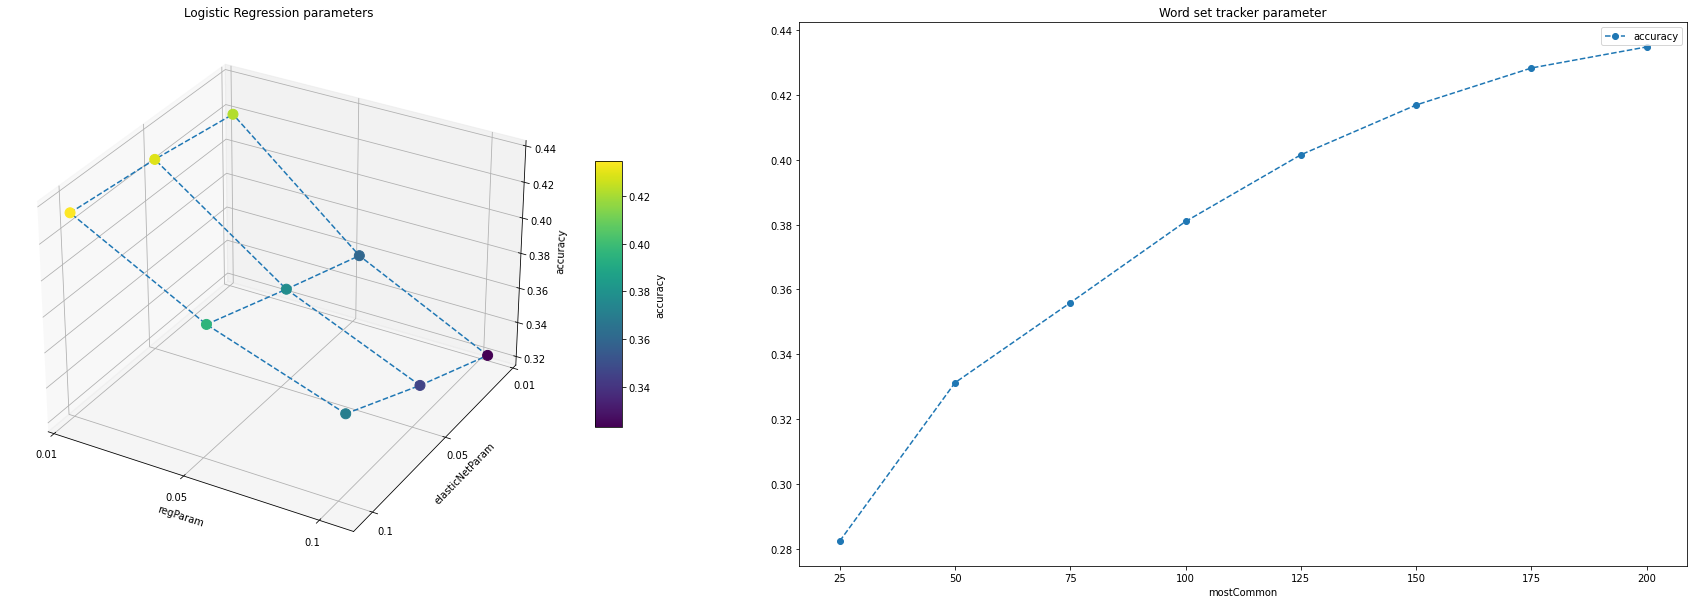

In [41]:
# now we can start plotting:
from matplotlib import cm
fig = plt.figure(figsize=(35,10))
ax2 = fig.add_subplot(122)
ax = fig.add_subplot(121, projection='3d')
ax.w_xaxis.set_ticks(x + 0.1)
ax.w_yaxis.set_ticks(y + 0.1)
ax.w_xaxis.set_ticklabels(regParams)
ax.w_yaxis.set_ticklabels(elasticNetParams)
ax.set_xlabel('regParam')
ax.set_ylabel('elasticNetParam')
ax.set_zlabel('accuracy')

# ax.invert_xaxis()
ax.invert_yaxis()
# ax.bar3d(x_m.ravel(), y_m.ravel(), np.zeros_like(accuracy_vals), dx=0.5, dy=0.5, dz=accuracy_vals)
cmhot = plt.get_cmap("viridis")
ax.plot_wireframe(x_m, y_m, accuracy_m, ls='dashed')
pts = ax.scatter3D(x_m, y_m, accuracy_m, s=100, cmap=cmhot, c=accuracy_m, depthshade=False)
cax = fig.colorbar(pts, shrink=1, aspect=10, fraction=0.03)
cax.set_label('accuracy')
ax.title.set_text("""Logistic Regression parameters""")
# and now plot accuracy as a function of most common words used for the best values of
# regParam and elasticNetParam:
mcax=mostcommon_df.plot(y='accuracy', ax=ax2, style='--o')
ax2.title.set_text('Word set tracker parameter')

---
# Target Word Set Evaluation

During the feature engineering (see [reviewed_grapes.feature_eng.pyspark.v1.ipynb](reviewed_grapes.feature_eng.pyspark.v1.ipynb)) we created several target word sets:

- Common words: Simply the most common words in the lemmatized version of review texts.
- Similar words*: Words with a vector representation close to the vector representation of a wine variety. 
- Dissimilar words*: Words with a vector representation opposite to the vector representation of a wine variety. 
- Extremes words*: Combination of similar and dissimilar words (most similar followed by most dissimilar, etc.).
- Low entropy words*: We picked words that presented a distribution of similarities (towards wine varieties) with a low information entropy.

_*: Based on deep learning._

Now the question is: _Which target word set leads to the best performing model?_

The way our `WordSetTracker` is defined (recall that the target word set is just a parameter) allows us to answer this question directly by cross validation of parameter sets over a parameter grid.

**The CrossValidator will simply tell us which target word set performed best.**

In [6]:
# load the dataset
reviews_sdf = spark.read.parquet('data/reviews_cleaned')

In [7]:
# get all the word sets:
with open('data/targetWordSets/common_words.json', 'r') as fo:
    common_words = json.load(fo)
with open('data/targetWordSets/similar_words.json', 'r') as fo:
    similar_words = json.load(fo)
with open('data/targetWordSets/dissimilar_words.json', 'r') as fo:
    dissimilar_words = json.load(fo)
with open('data/targetWordSets/extreme_words.json', 'r') as fo:
    extremes_words = json.load(fo)
with open('data/targetWordSets/lowentropy_words.json', 'r') as fo:
    lowentropy_words = json.load(fo)

In [8]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [9]:
si = StringIndexer(inputCol='variety', outputCol='label')
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))
# we also define a custom blacklist:
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
# complete the list with our custom blacklist:
stop_words = list(en_stopwords.union(blacklist))
# instatiate our transformer and the estimator:
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)

# initialize our word set tracker without wordSet and limitTo:
wst = WordSetTracker(inputCol='words', outputCol='features')

# init the logistic regression with optimized params:
mlrc = LogisticRegression(regParam=0.01, elasticNetParam=0.01)

To start we only apply the lemmatization and use the resulting dataset:

In [10]:
lemmatized = Pipeline(stages=[si, nltkl]).fit(reviews_sdf
                                        ).transform(reviews_sdf).toDF('id', 'description',
                                                                      'variety', 'label', 'words')
# we will use the validation_ds at the very end to check how well our model performs on unseen data.
review_ds, validation_ds = lemmatized.randomSplit([0.9, 0.1])

In [11]:
ppl = Pipeline(stages=[wst, mlrc])
# create an evaluator to use (or use the already defined accuracy)
accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
# construct the grid
# we will use a multiple of the # of varieties as length
nbr_labels = 57
paramGrid = ParamGridBuilder() \
    .addGrid(wst.limitTo, [i * nbr_labels for i in range(1, 15)]) \
    .addGrid(wst.wordSet, [common_words, similar_words, dissimilar_words, extremes_words, lowentropy_words]) \
    .build()


In [12]:
# where we will store the model:
cvmodel_acc = 'data/evaluation/targetWordSets_corssValidated_model_acc'
# now create the corssvalidator for accuracy
tws_crossValidator_acc = CrossValidator(estimator=ppl,
                                    estimatorParamMaps=paramGrid,
                                    evaluator=accuracy,
                                    numFolds=3)

In [13]:
cvmodel_f1 = 'data/evaluation/targetWordSets_corssValidated_model_f1'
# and the one based on averaged f-score
tws_crossValidator_f1 = CrossValidator(estimator=ppl,
                                    estimatorParamMaps=paramGrid,
                                    evaluator=f1,
                                    numFolds=3)

In [14]:
%%time
tws_model_crossvalid_acc = tws_crossValidator_acc.fit(review_ds)
tws_model_crossvalid_acc.write().overwrite().save(cvmodel_acc)

CPU times: user 12.7 s, sys: 5.09 s, total: 17.8 s
Wall time: 3h 41min 8s


In [15]:
%%time
tws_model_crossvalid_f1 = tws_crossValidator_f1.fit(review_ds)
tws_model_crossvalid_f1.write().overwrite().save(cvmodel_f1)

CPU times: user 12.9 s, sys: 5.6 s, total: 18.5 s
Wall time: 3h 42min 39s


In [ ]:
# load the model if we have previously run it
tws_model_crossvalid_acc = CrossValidatorModel.load(cvmodel_acc)
tws_model_crossvalid_f1 = CrossValidatorModel.load(cvmodel_f1)

In [23]:
pred_train_acc = tws_model_crossvalid_acc.transform(review_ds)
pred_train_acc.show()

+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|           variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|(798,[1,3,4,5,9,2...|[0.76921949424911...|[0.01193486745275...|       6.0|
|  1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|(798,[1,5,6,8,14,...|[3.64846518214006...|[0.03792593579734...|       4.0|
|  2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|(798,[0,5,29,49,6...|[2.08052488468735...|[0.01349269094409...|       6.0|
|  3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|(798,[2,3,4,10,55...|[-0.1322748081201...|[0.0

In [24]:
pred_train_f1 = tws_model_crossvalid_f1.transform(review_ds)
pred_train_f1.show()

+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| id|         description|           variety|label|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|(798,[1,3,4,5,9,2...|[0.76921949424911...|[0.01193486745275...|       6.0|
|  1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|(798,[1,5,6,8,14,...|[3.64846518214006...|[0.03792593579734...|       4.0|
|  2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|(798,[0,5,29,49,6...|[2.08052488468735...|[0.01349269094409...|       6.0|
|  3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|(798,[2,3,4,10,55...|[-0.1322748081201...|[0.0

In [18]:
info('How well is the best **accuracy-evaluated model** performing?:')
info(f'- Accuracy: **{round(accuracy.evaluate(pred_train_acc)*100, 1)}%**')
info(f'- F1 score: **{round(f1.evaluate(pred_train_acc), 4)}**')
pred_test_acc = tws_model_crossvalid_acc.transform(validation_ds)
info('How well are we doing on the validation dataset?:')
info(f'- Accuracy: **{round(accuracy.evaluate(pred_test_acc)*100, 1)}%**')
info(f'- F1 score: **{round(f1.evaluate(pred_test_acc), 4)}**')

<span style="color:blue">How well is the best **accuracy-evaluated model** performing?:</span>

<span style="color:blue">- Accuracy: **55.7%**</span>

<span style="color:blue">- F1 score: **0.5242**</span>

<span style="color:blue">How well are we doing on the validation dataset?:</span>

<span style="color:blue">- Accuracy: **52.3%**</span>

<span style="color:blue">- F1 score: **0.4874**</span>

In [19]:
info('How well is the best **fscore-evaluated model** performing?:')
info(f'- Accuracy: **{round(accuracy.evaluate(pred_train_f1)*100, 1)}%**')
info(f'- F1 score: **{round(f1.evaluate(pred_train_f1), 4)}**')
pred_test_f1 = tws_model_crossvalid_f1.transform(validation_ds)
info('How well are we doing on the validation dataset?:')
info(f'- Accuracy: **{round(accuracy.evaluate(pred_test_f1)*100, 1)}%**')
info(f'- F1 score: **{round(f1.evaluate(pred_test_f1), 4)}**')

<span style="color:blue">How well is the best **fscore-evaluated model** performing?:</span>

<span style="color:blue">- Accuracy: **55.7%**</span>

<span style="color:blue">- F1 score: **0.5242**</span>

<span style="color:blue">How well are we doing on the validation dataset?:</span>

<span style="color:blue">- Accuracy: **52.3%**</span>

<span style="color:blue">- F1 score: **0.4874**</span>

## Visualization of target word set performances

In [20]:
# make it easy to map target word sets to a name
tws = {
    'Common Words': common_words,
    'Similar Words': similar_words,
    'Dissimilar Words': dissimilar_words,
    'Extremes Words': extremes_words,
    'Low Entropy Words': lowentropy_words
}

Now we combine our evaluations in a pandas df:

In [21]:
# First we construct a multy level index (same for both accuracy and f1)
estimatormaps = tws_model_crossvalid_acc.getEstimatorParamMaps()
param_names = tuple(p.name for p in estimatormaps[0])
param_values = [tuple(v for v in m.values()) for m in estimatormaps]
for i, param in enumerate(param_values):
    alist = param[1]
    for ws_name, ws in tws.items():
        if alist == ws:
            name = ws_name
            break
    param_values[i] = (param_values[i][0], name)

In [22]:
# now we get accuracy and f score 
columns = ('accuracy', 'F-score')
avg_acc = tws_model_crossvalid_acc.avgMetrics  # average over the folds
avg_f1 = tws_model_crossvalid_f1.avgMetrics  # average over the folds
values = list(zip(avg_acc, avg_f1))
index = pd.MultiIndex.from_tuples(param_values, names=param_names)
# put it all into a pandas df (make further processing easier)
all_params_df = pd.DataFrame(values, columns=columns, index=index)
df_name = 'data/interim/tws_evaluation_pdDF'
all_params_df.to_pickle(df_name)
all_params_df

accuracy   F-score
limitTo wordSet                              
57      Common Words       0.339791  0.273389
        Similar Words      0.227009  0.176052
        Dissimilar Words   0.156526  0.098341
        Extremes Words     0.210935  0.163081
        Low Entropy Words  0.210954  0.152447
...                             ...       ...
798     Common Words       0.519702  0.483636
        Similar Words      0.485363  0.447921
        Dissimilar Words   0.462139  0.421805
        Extremes Words     0.488397  0.449043
        Low Entropy Words  0.498576  0.460759

[70 rows x 2 columns]

In [50]:
# in case we saved it and don't want to rerun everything:
all_params_df = pd.read_pickle(df_name)

In [ ]:
# finally include the marginal maximizer as baseline
name = 'reviewed_grapes/fitted_models/MarginalModel'
marginal_model = PipelineModel.load(name)
marg_pred = marginal_model.transform(validation_ds)
baseline_acc = accuracy.evaluate(marg_pred)
baseline_f1 = f1.evaluate(marg_pred)

Text(0, 0.5, 'F-score')

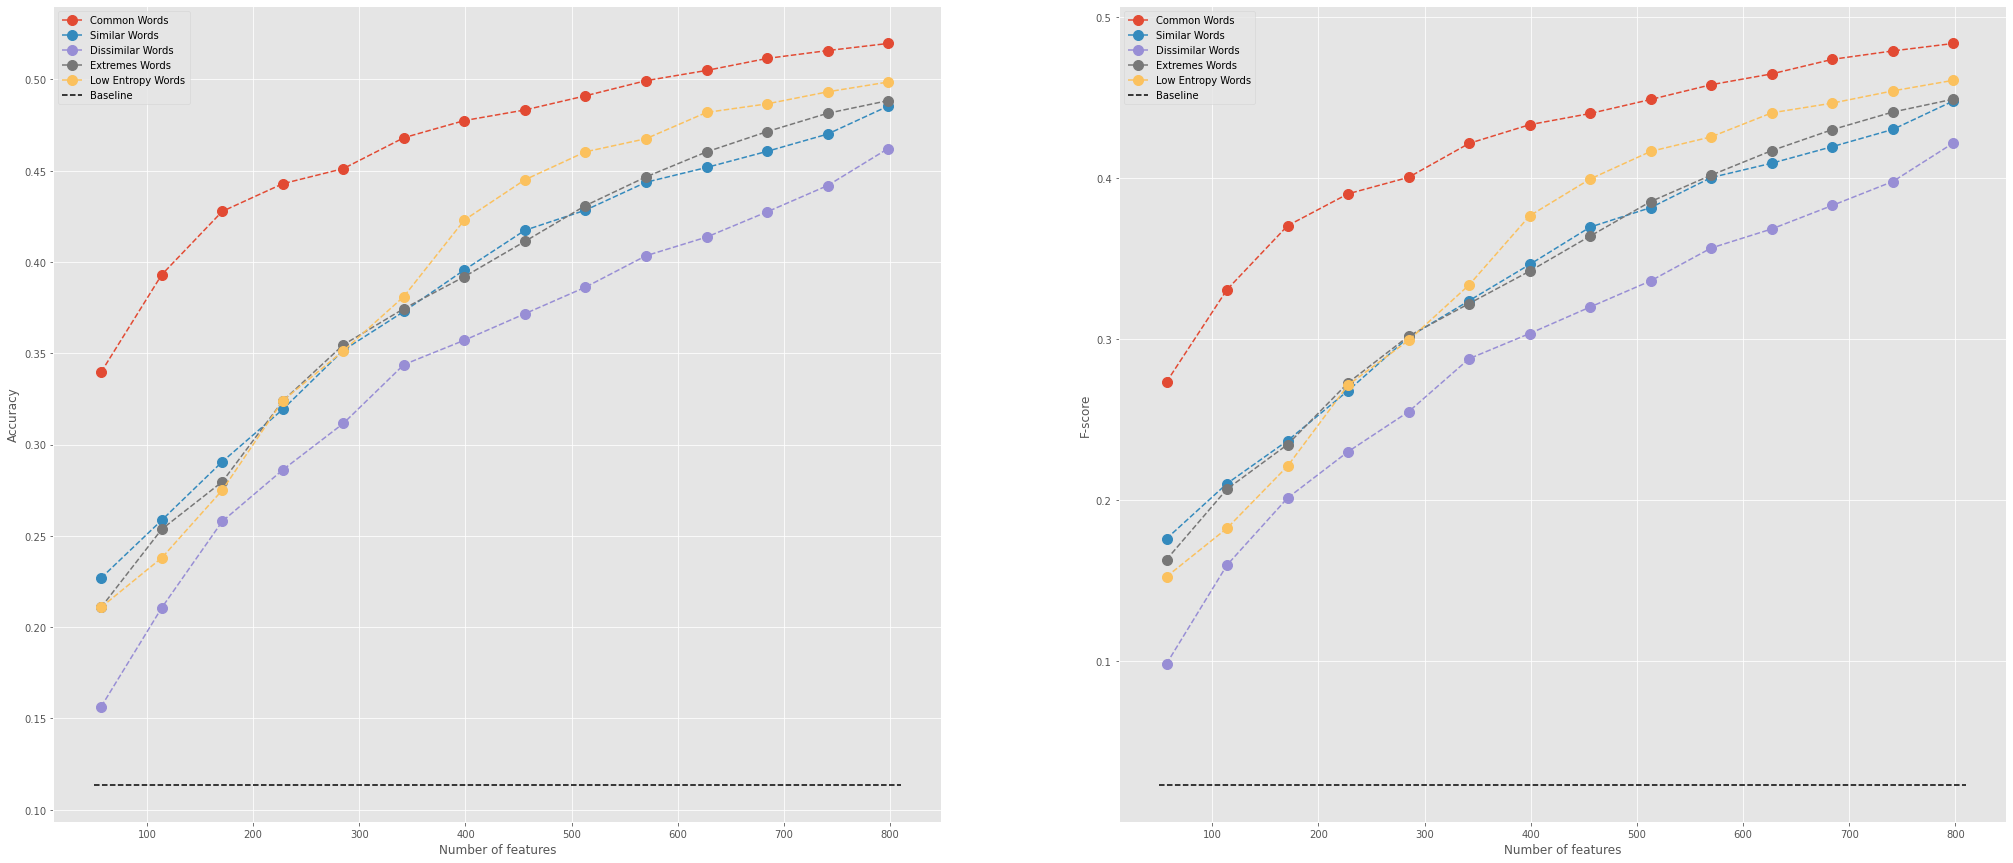

In [36]:
from matplotlib.lines import Line2D
from matplotlib import cm
plt.style.use('ggplot')
fig = plt.figure(figsize=(35,15))
ax2 = fig.add_subplot(122)
ax1 = fig.add_subplot(121)

for name in tws.keys():
    all_params_df.xs(name, level=1, axis=0, drop_level=True) \
        .plot(y='accuracy', ax=ax1, style='--o', label=name, ms=10)
    all_params_df.xs(name, level=1, axis=0, drop_level=True) \
        .plot(y='F-score', ax=ax2, style='--o', label=name, ms=10)
ax1.hlines(baseline_acc, 50, 810, colors='black', ls='dashed', label='Baseline')
ax2.hlines(baseline_f1, 50, 810, colors='black', ls='dashed', label='Baseline')
# just to force updateing the lengend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles)

ax1.set_xlabel('Number of features')
ax2.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('F-score')


---